# Trabajo Practico 1 - Que No Se Escape Nadie (?)

## Introduccion:

En el presente trabajo se analizara una base de datos de la empresa FIUBAFIP con el objetivo de entender la información que fue recolectada y poder predecir aquellas personas que tiene alto o bajo poder adquisitivo.

### Objetivos:

- Entender la base de datos.
- Ver cómo los datos se relacionan entre sí.
- Poder sacar alguna conclusión o descubrir un patrón a partir de estos.
- Indicar cuáles son los factores más importantes que determinan el poder adquisitivo de una persona.
- Poder llegar a armar un baseline

### Bibliotecas utilizadas:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [2]:
sns.set_theme(style="whitegrid", palette='muted')
heatmap_paleta = "Blues"

## Feature enginnering:

In [3]:
GSPREADHSEET_DOWNLOAD_URL = ("https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format)
FIUFIP_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_GID), skiprows=0)

Antes de iniciar un análisis sobre los datos, debemos verificar que no contiene información inválida o que no sea útil para el análisis.

Inicialmente buscaremos missings (atributos que no fueron cargados).

In [4]:
df.isna().any()

anios_estudiados                              False
barrio                                         True
categoria_de_trabajo                           True
edad                                          False
educacion_alcanzada                           False
estado_marital                                False
ganancia_perdida_declarada_bolsa_argentina    False
genero                                        False
horas_trabajo_registradas                     False
religion                                      False
rol_familiar_registrado                       False
tiene_alto_valor_adquisitivo                  False
trabajo                                        True
dtype: bool

Como podemos ver existen 3 campos en donde no tenemos la información de todas las instancias. Por lo que ahora deberemos analizar cada situación y tomar un criterio para decidir qué hacer con estas instancias con valores inválidos.

Con este script podemos ver cuántas instancias tiene nulos y en qué campos. De esta manera vemos que existen 27 personas que no completan las columnas barrio, categoria_de_trabajo y trabajo. Al ser un grupo pequeño y tener valores inválidos en categoría que a priori parecen ser relevantes (categoria_de_trabajo y trabajo) decidimos descartarlos.

In [5]:
def tiene_n_missings(x, n):
    acum = 0
    for i in range(len(x)):
        if x[i]:
            acum += 1
    return n <= acum


lista_de_missings = [tiene_n_missings(x, 3) for x in df.isna().to_numpy()]

df_3_missings = df.reset_index()[lista_de_missings].set_index('index')
df_3_missings.isnull().sum()

anios_estudiados                               0
barrio                                        27
categoria_de_trabajo                          27
edad                                           0
educacion_alcanzada                            0
estado_marital                                 0
ganancia_perdida_declarada_bolsa_argentina     0
genero                                         0
horas_trabajo_registradas                      0
religion                                       0
rol_familiar_registrado                        0
tiene_alto_valor_adquisitivo                   0
trabajo                                       27
dtype: int64

In [6]:
df.drop(df_3_missings.index, inplace = True)

Luego hacemos la misma lógica para analizar a las personas con 2 campos nulos.

In [7]:
lista_de_missings = [tiene_n_missings(x, 2) for x in df.isna().to_numpy()]

df_2_missings = df.reset_index()[lista_de_missings].set_index('index')
df_2_missings.isnull().sum()

anios_estudiados                                 0
barrio                                           0
categoria_de_trabajo                          1809
edad                                             0
educacion_alcanzada                              0
estado_marital                                   0
ganancia_perdida_declarada_bolsa_argentina       0
genero                                           0
horas_trabajo_registradas                        0
religion                                         0
rol_familiar_registrado                          0
tiene_alto_valor_adquisitivo                     0
trabajo                                       1809
dtype: int64

Podemos notar que existen una gran cantidad de personas que no contesto cual es su trabajo. Como inicialmente el campo trabajo es una valor a tener en cuenta para poder decidir el valor adquisitivo decidimos crear un nuevo campo "No contesto" para no tener que descartar todos estos datos.

In [8]:
df = df.replace({'trabajo': np.nan, 'categoria_de_trabajo': np.nan},'No contesto')
df['trabajo'].isna().any() 

False

Por ultimo nos queda analizar cuantas son las instancias con un Nan. 

Como podemos ver existen 556 personas que no completaron su barrio. En esta ocasion decidimos analizar la cantidad de personas que viven en todos los barrios. Podemos notar que mas de un 90% vive en Palermo por lo que nos resulto correcto incluir a estas instancias en este barrio.

In [9]:
lista_de_missings = [tiene_n_missings(x, 1) for x in df.isna().to_numpy()]

df_missing = df.reset_index()[lista_de_missings].set_index('index')
df_missing.isnull().sum()

anios_estudiados                                0
barrio                                        556
categoria_de_trabajo                            0
edad                                            0
educacion_alcanzada                             0
estado_marital                                  0
ganancia_perdida_declarada_bolsa_argentina      0
genero                                          0
horas_trabajo_registradas                       0
religion                                        0
rol_familiar_registrado                         0
tiene_alto_valor_adquisitivo                    0
trabajo                                         0
dtype: int64

In [10]:
df['barrio'].value_counts(normalize = True).head(10)

Palermo          0.912190
Belgrano         0.020108
San Isidro       0.006192
Villa Urquiza    0.004284
Recoleta         0.003784
La Boca          0.003565
Agronomia        0.003315
Almagro          0.003127
Balvanera        0.002971
Puerto Madero    0.002814
Name: barrio, dtype: float64

In [11]:
df = df.replace({'barrio': np.nan},'Palermo')

Al hacer este análisis notamos la gran cardinalidad de la variable barrio. Para poder analizar más fácilmente esta variable decidimos agrupar a los distintos barrios por sus comunas.

In [12]:
mapa = {'Palermo' : 'C14','Belgrano' : 'C13','San Isidro' : 'S.I','Villa Urquiza' : 'C12','Recoleta' : 'C2','La Boca' : 'C4','Agronomia' : 'C15','Almagro' : 'C5','Balvanera' : 'C3','Puerto Madero' : 'C1','Caballito' : 'C6','Boedo' : 'C5','Barracas' : 'C4','Chacarita' : 'C15','Coghland' : 'C12','Floresta' : 'C10','Constitucion' : 'C1','Colegiales' : 'C13','Flores' : 'C7','Liniers' : 'C9','Monte Castro' : 'C10','Mataderos' : 'C9','Nueva Pompeya' : 'C4','Monserrat' : 'C1','nuñez' : 'C13','Parque Chacabuco' : 'C7','Parque Avellaneda' : 'C9','Villa Luro' : 'C10','Parque Chas' : 'C15','La Paternal' : 'C15','Retiro' : 'C1','Villa Devoto' : 'C11','Villa Soldati' : 'C8','San Telmo' : 'C1','Villa Real' : 'C10','Santa Rita' : 'C11','Villa General Mitre' : 'C11','Versalles' : 'C10','Velez Sarsfield' : 'C10','Villa Pueyrredon' : 'C12','Cilla Riachuelo' : 'C8'}
df['comuna'] = df['barrio'].apply(lambda x: mapa.get(x))

Notamos que existe un grupo de gente que apesar de figurar como sin trabajo tiene un numero mayor a cero de horas_de_trabajo_registrada. Decidimos descartarlas por ser instancias con informacion contradictoria.

In [13]:
df_gente_sin_trabajo_con_horas_registradas = df[(df['categoria_de_trabajo'] == 'sin_trabajo') & (df['horas_trabajo_registradas'] > 0)]
df.drop(df_gente_sin_trabajo_con_horas_registradas.index, inplace = True)

#### Variables similares

Luego analizando las variables por separado encontramos que para rol familiar y estado marital existen dos categorías similares, las cuales presentan la misma distribución.

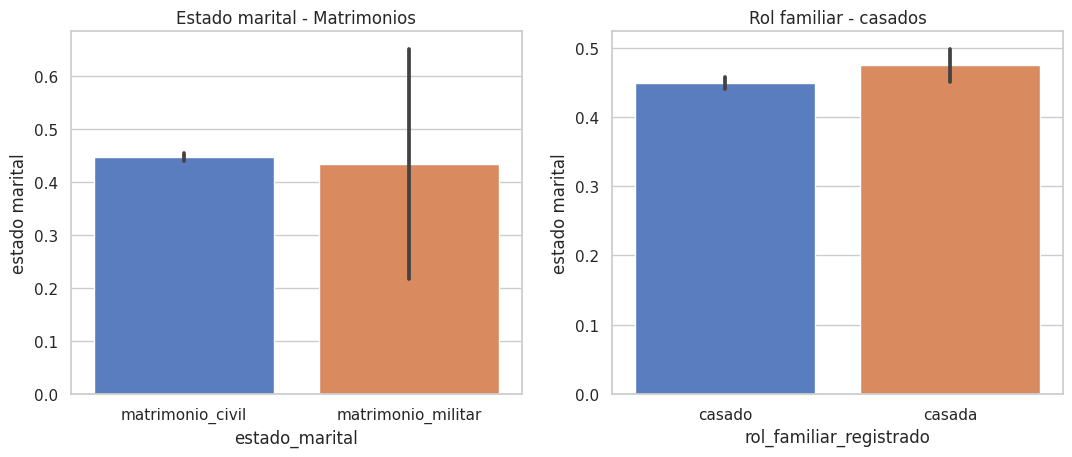

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)
sns.barplot(
    data=df[(df['estado_marital'] == 'matrimonio_civil') | (df['estado_marital'] == 'matrimonio_militar')],
    y='tiene_alto_valor_adquisitivo',
    x='estado_marital', ax=axes[0])

axes[0].set_title("Estado marital - Matrimonios")
axes[0].set_ylabel("estado marital")

sns.barplot(
    data=df[(df['rol_familiar_registrado'] == 'casado') | (df['rol_familiar_registrado'] == 'casada')],
    y='tiene_alto_valor_adquisitivo',
    x='rol_familiar_registrado', ax=axes[1])

axes[1].set_title("Rol familiar - casados")
axes[1].set_ylabel("estado marital")

plt.show()

Como podemos observar en los graficos la informacion que aporta para estimar a la funcion target, el matrimonio civil y el militar es exactamente la misma (lo mismo ocurre para casado y casada). Es por ello que decidimos combinarlas en una misma categoria matrimonio y casado respectivamente.

In [15]:
df['rol_familiar_registrado'] = df['rol_familiar_registrado'].apply(lambda x: 'casado' if x == 'casada' else x)
df['estado_marital'] = df['estado_marital'].apply(lambda x: 'matrimonio' if x == 'matrimonio_civil' or x == 'matrimonio_militar' else x)

También podemos notar que la educación alcanzada y años estudiados nos aportan la misma información. Una es una simple categorización de la otra como se puede observar:

In [16]:
mapa = {'preescolar': 1,
        '1-4_grado': 4,
        '5-6_grado': 6,
        '7-8_grado': 8,
        '9_grado': 9,
        '1_anio': 10,
        '2_anio': 11,
        '3_anio': 12,
        '4_anio': 13,
        '5_anio': 14,
        'universidad_1_anio': 15,
        'universidad_2_anio': 16,
        'universidad_3_anio': 17,
        'universidad_4_anio': 18,
        'universiada_5_anio' : 19,
        'universiada_6_anio' : 20}
educacion_alcanzada = df['educacion_alcanzada'].apply(lambda x: mapa.get(x))
df['anios_estudiados'].equals(educacion_alcanzada)

True

Por lo tanto como no se pierde informacion y para poder reducir la dimensionalidad se decide eliminar esta columna redundante.

In [17]:
df = df.drop(['educacion_alcanzada'],axis=1)

## Analisis de los datos:

Para el análisis empezamos haciéndonos algunas preguntas, y en cada caso al surgir alguna nueva pregunta interesante se continuará su desarrollo en esa sección.

- ¿Que tanto influye tener una familia en el poder adquisitivo?
    - ¿Como se relaciona con el rol familiar?
- ¿Operar con la bolsa da evidencia de un inversor de mayor capital?
- ¿Que profesiones son más determinantes?
    - ¿Se relaciona el trabajo con el estado matiral?
    - ¿Que informacion nos aporta con respecto a la categoria de trabajo?
    - ¿Trabajar mas hace la diferencia?
- ¿Que nivel de formación académica es necesaria?
    - ¿Que tanto influye la educacion en el trabajo?
- ¿Es realmente influyente el domicilio legal?
- Tomando a la edad como un indicador promedio en la experiencia laboral. ¿Que tanto peso tiene con respecto a la capacidad financiera?
    - ¿Existe una relacion entre el trabajo o el estado marital y la edad de una persona?
- ¿Es influyente factores como la religion o el genero para determinar el poder adquisitivo?


#### Constantes globales

Se definen las siguientes constantes para evitar repetir codigo y funciones que nos permiten emprolijar el Notebook.

In [18]:
df_alto_valor_ad = df[df.tiene_alto_valor_adquisitivo == 1]
df_bajo_valor_ad = df[df.tiene_alto_valor_adquisitivo == 0]

def stacked_barplot(df, categoria, axes=None, orden=True):
    total = df.groupby(categoria)['tiene_alto_valor_adquisitivo'].sum().reset_index()
    alto_valor = df[df.tiene_alto_valor_adquisitivo == 1].groupby(categoria)['tiene_alto_valor_adquisitivo'].sum().reset_index()
    
    alto_valor['tiene_alto_valor_adquisitivo'] = df[df.tiene_alto_valor_adquisitivo == 1].groupby(categoria)['tiene_alto_valor_adquisitivo'].sum().reset_index()['tiene_alto_valor_adquisitivo'].tolist()
    total['tiene_alto_valor_adquisitivo'] = df.groupby(categoria)[categoria].apply(lambda x: len(x)).tolist()

    if orden:
        orden = total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)[categoria]
    else:
        orden = None
    
    bar1 = sns.barplot(y="tiene_alto_valor_adquisitivo",  x=categoria, data=total, color='#D17049', order = orden, ax=axes)
    bar2 = sns.barplot(y="tiene_alto_valor_adquisitivo", x=categoria, data=alto_valor, color='#89D15E', order = orden, ax=axes)
    top_bar = mpatches.Patch(color='#D17049', label='Bajo')
    bottom_bar = mpatches.Patch(color='#89D15E', label='Alto')
    return (top_bar, bottom_bar, bar1, bar2)



### ¿Que tanto influye tener una familia en el poder adquisitivo?

Para responder esta pregunta inicialmente podemos hacer el siguiente grafico que muestra a los distintos estados maritales y su cantidad de personas que poseen alto y bajo valor adquisitivo.

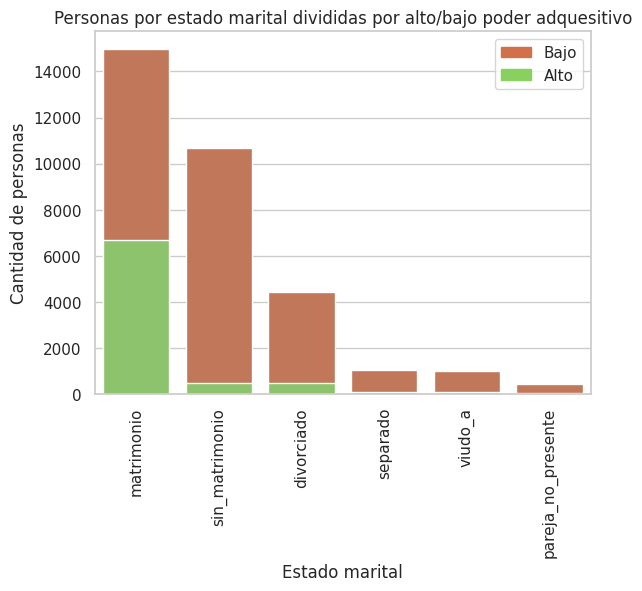

In [19]:
plt.figure(figsize=(6.4, 4.8),  dpi=100)

(top_bar, bottom_bar, _, _) = stacked_barplot(df, 'estado_marital')

plt.legend(handles=[top_bar, bottom_bar])
plt.title("Personas por estado marital divididas por alto/bajo poder adquesitivo")
plt.ylabel("Cantidad de personas")
plt.xlabel("Estado marital")
plt.xticks(rotation = 90)

plt.show()

Podemos notar una marcada diferencia para las personas que tienen un matrimonio siendo el 45% de las personas en matrimonio personas con alto poder adquisitivo, en comparación a las demás posibilidades que poseen un promedio similar bastante menor de personas con alto poder adquisitivo, También nos parece importante resaltar la separación entre la población que cumple tener poder adquisitivo alto y la que no, como vemos la gran mayoría de las personas con poder adquisitivo alto están casadas, mientras que en el caso contrario la mayoría no posee matrimonio, consideramos que esta puede ser una buena regla de decisión.

#### ¿Como se relaciona con el rol familiar?

Para ello se nos ocurrio un heatmap que evidencie si hay correlacion entre una y la otra.

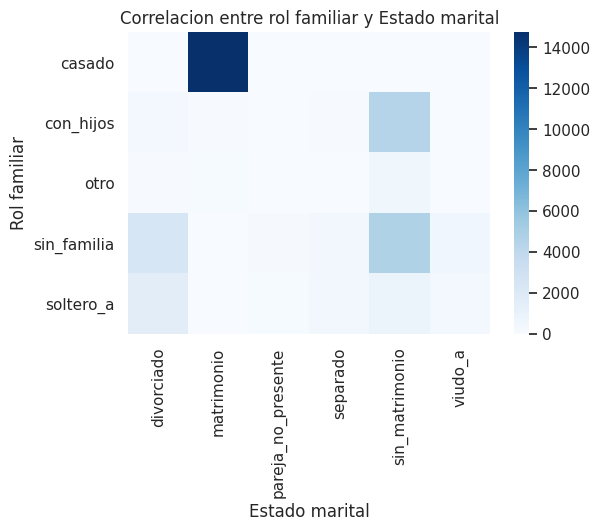

In [20]:
df_temp = df.copy()
df_temp['unos'] = [1] * 32527
df_estado_marital= pd.pivot_table(
    df_temp,
    'unos',
    'rol_familiar_registrado',
    'estado_marital',
    'count',
).sort_index()
#Elimino intersecciones nulas
df_estado_marital = df_estado_marital.replace({np.nan: 0})

plt.figure(dpi=100)
ax = sns.heatmap(df_estado_marital, square=True, cmap=heatmap_paleta)
ax.set(xlabel='Estado marital', ylabel='Rol familiar', title='Correlacion entre rol familiar y Estado marital')
plt.show()

Como era de esperarse la relacion entre estas dos variables es bastante estrecha ya que la gran mayoria de la gente que esta casada esta en un matrimonio, mientras que en el resto de variables la variacion es muy pequeña.

### ¿Que profesiones son mas determinantes?

Sabemos que distintas profesiones tienen distintos ingresos, por lo tanto podriamos esperar que las profesiones con mayor remuneracion tengan un mayor porcentaje con alto poder adquisitivo.

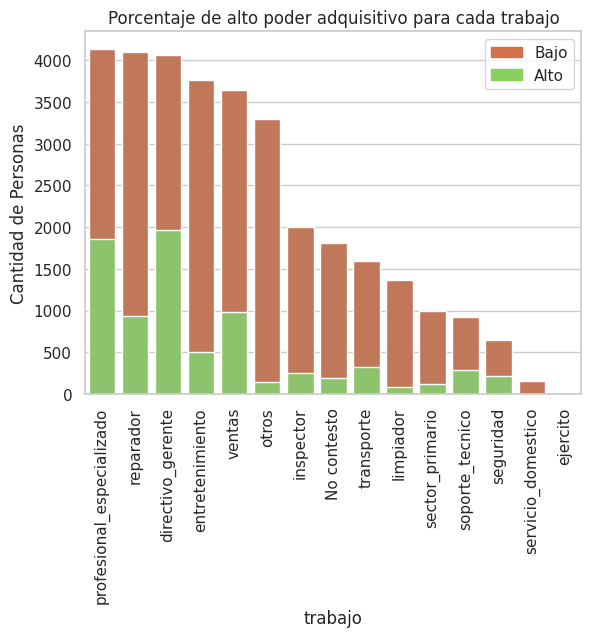

In [21]:
plt.figure(figsize=(6.4, 4.8),  dpi=100)

(top_bar, bottom_bar, _,_) = stacked_barplot(df, 'trabajo')

plt.legend(handles=[top_bar, bottom_bar])
plt.title("Porcentaje de alto poder adquisitivo para cada trabajo")
plt.ylabel("Cantidad de Personas")
plt.xticks(rotation = 90)

plt.show()

 Notamos un gran porcentaje de profesionales y gerentes con alto poder adquisitivo, mientras que en las demas profesiones el porcentaje no supera el 20%. 

#### ¿Se relaciona el trabajo con el estado marital?

Hasta ahora encontramos 2 características que influyen significativamente en decidir si tiene poder adquisitivo. Puede ser que estas dos variables estén relacionadas, en caso de ser así se podría comenzar a definir un patrón.

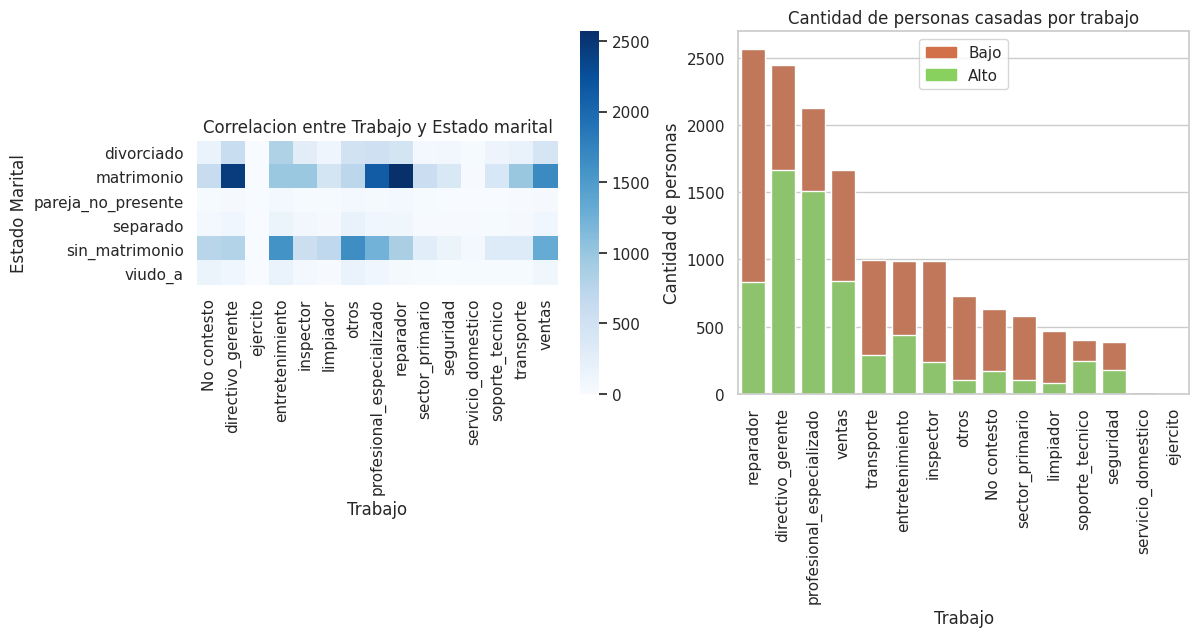

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_temp = df.copy()

df_temp['unos'] = [1] * 32527
df_estado_marital= pd.pivot_table(
    df_temp,
    'unos',
    'estado_marital',
    'trabajo',
    'count',
).sort_index()
#Elimino intersecciones nulas
df_estado_marital = df_estado_marital.replace({np.nan: 0})

sns.heatmap(df_estado_marital, square=True, cmap=heatmap_paleta, ax = axes[0])
axes[0].set(xlabel='Trabajo', ylabel='Estado Marital', title='Correlacion entre Trabajo y Estado marital')


df_matrimonio = df[df['estado_marital'] == 'matrimonio']

(top_bar, bottom_bar, bar1,bar2) = stacked_barplot(df_matrimonio, 'trabajo', axes=axes[1])


axes[1].legend(handles=[top_bar, bottom_bar])
axes[1].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas casadas por trabajo')
bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)

plt.show()

Encontramos que existe una relación entre las profesiones con mayor porcentaje de poder adquisitivo (gerente y profesional especializado) y el estado marital. Por lo que ahora queremos ver cómo se distribuye la población casada en los distintos trabajos.

Con el gráfico de la derecha vemos que al condicionar a la gente que tiene matrimonio, conservamos un porcentaje alto (84%) de la gente con poder adquisitivo alto, descartando también bastante población de poder adquisitivo bajo (66%). Notamos que bajo esta condición ciertos porcentaje aumentaron considerablemente, son los casos de gerente y profesional especializado. Pero también están los casos de ventas, entretenimiento, soporte técnico y seguridad que también mejoraron la cantidad de personas con poder adquisitivo alto luego de condicionar.

#### ¿Que informacion nos aporta con respecto a la categoria de trabajo?

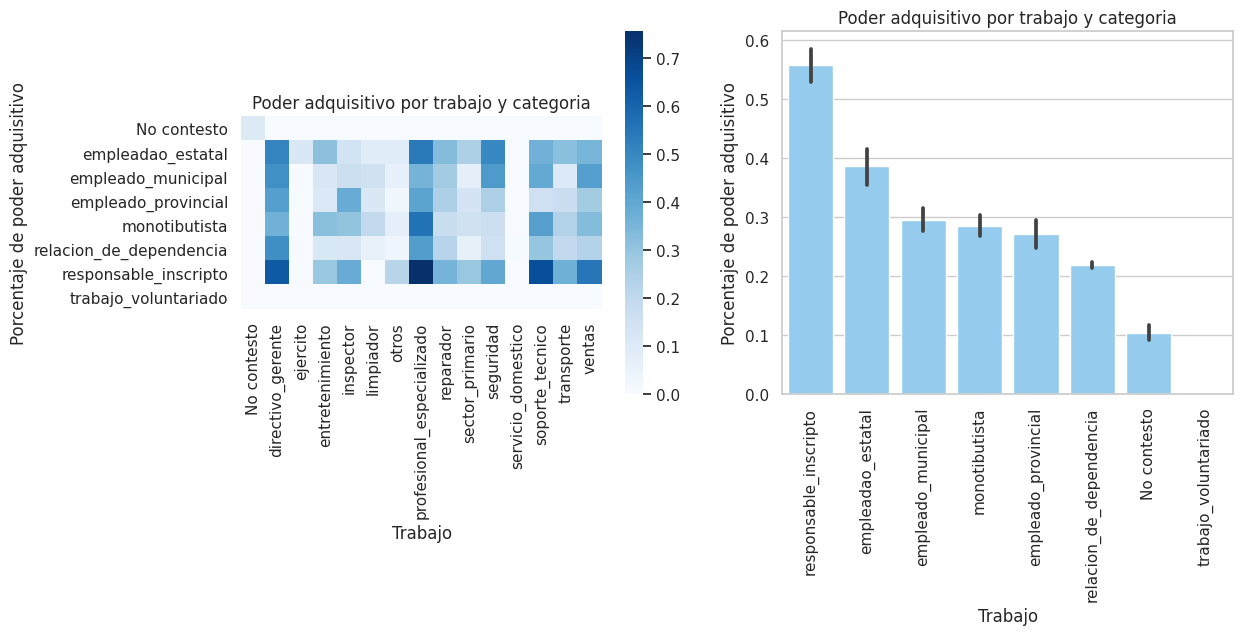

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_temp['unos'] = [1] * 32527
df_tabla_trabajo= pd.pivot_table(
    df_temp,
    'tiene_alto_valor_adquisitivo',
    'categoria_de_trabajo',
    'trabajo',
    'mean'
).sort_index()
#Elimino intersecciones nulas
df_tabla_trabajo = df_tabla_trabajo.replace({np.nan: 0})

sns.heatmap(df_tabla_trabajo, square=True, cmap=heatmap_paleta,  ax = axes[0])
axes[0].set(xlabel = 'Trabajo', ylabel= 'Porcentaje de poder adquisitivo', title = 'Poder adquisitivo por trabajo y categoria')

indices = df.groupby('categoria_de_trabajo')['tiene_alto_valor_adquisitivo'].aggregate(lambda x: np.mean(x))
bar = sns.barplot(
    data=df,
    x='categoria_de_trabajo',
    y='tiene_alto_valor_adquisitivo',
    color = "lightskyblue",
    order= indices.sort_values(ascending=False).index,
    ax = axes[1])
bar.set_xticklabels(bar.get_xticklabels(),rotation=90)
axes[1].set(xlabel = 'Trabajo', ylabel= 'Porcentaje de poder adquisitivo', title = 'Poder adquisitivo por trabajo y categoria')
plt.show()



Como podemos ver, si bien responsable inscripto es la categoría con mayor poder adquisitivo, notamos que la categoría de trabajo tiene poca incidencia sobre el poder adquisitivo y este esta mejor representado solo por el trabajo ya que las zonas oscuras forman rectas verticales lo que nos indica que la gente de mayor poder adquisitivo solo es influida por la variable vertical que sería el trabajo.

#### ¿Trabajar mas hace la diferencia?

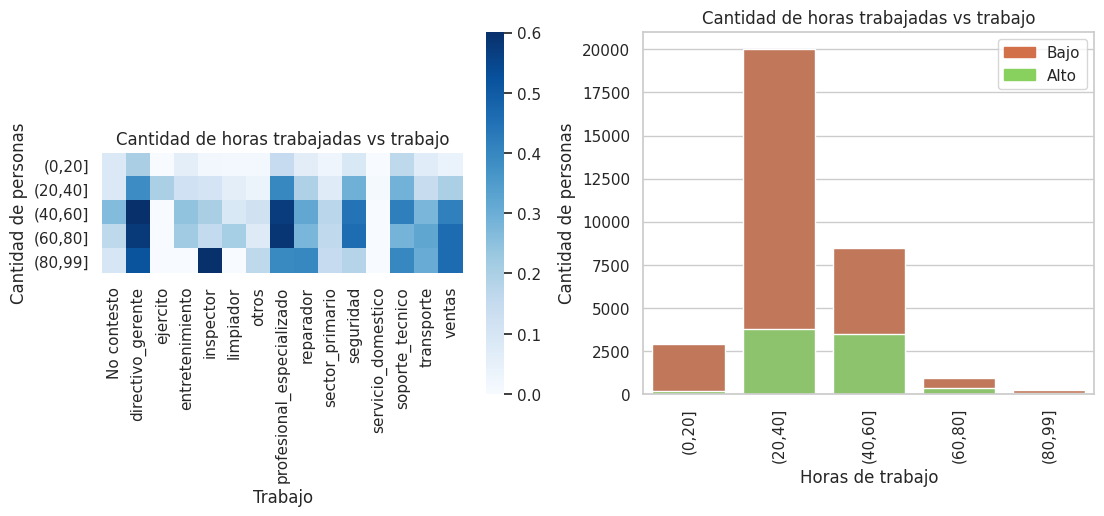

In [43]:
df_horas_categorizada = df[['tiene_alto_valor_adquisitivo','trabajo','horas_trabajo_registradas']].copy()
categoria = pd.cut(df_horas_categorizada.horas_trabajo_registradas,bins=[0,20,40,60,80,99],labels=['(0,20]', '(20,40]', '(40,60]', '(60,80]', '(80,99]'])
df_horas_categorizada.insert(2,"Grupo Horas de trabajo", categoria)
df_temp = df_horas_categorizada.copy()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_temp['unos'] = [1] * 32527
df_tabla_trabajo= pd.pivot_table(
    df_temp,
    'tiene_alto_valor_adquisitivo',
    'Grupo Horas de trabajo',
    'trabajo',
    'mean',
).sort_index()
#Elimino intersecciones nulas
df_tabla_trabajo = df_tabla_trabajo.replace({np.nan: 0})

sns.heatmap(df_tabla_trabajo, square=True, cmap=heatmap_paleta,  ax = axes[0])
axes[0].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de horas trabajadas vs trabajo')

(top_bar, bottom_bar, bar1,bar2) = stacked_barplot(df_horas_categorizada, 'Grupo Horas de trabajo', axes=axes[1], orden=False)

axes[1].legend(handles=[top_bar, bottom_bar])
axes[1].set(xlabel = 'Horas de trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de horas trabajadas vs trabajo')
bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)

plt.show()

Podemos notar como el gráfico anterior presenta dos grupos distintos, los que trabajan menos de 40 hs (70%) y los que trabajan mas de 40 hs (30%), entre el primero notamos que la gente que trabaja menos de 20 hs semanales definitivamente tiene un menor ingreso, mientras que la gente que cumple un horario más tradicional de 8 hs diarias aumenta su porcentaje con respecto al anterior grupo pero no lo suficiente como para poder plantear una regla de decisión satisfactoria, luego en el segundo grupo, vemos que el porcentaje relativo vuelve aumentar, pero aún mantiene una mayoría de gente con poder adquisitivo bajo, viendo las siguientes podemos notar la poca cantidad de personas en este grupo, haciendo que sea difícil inferir estadísticamente un patrón basándose en ellos.

Analizando la correlación con el trabajo podemos ver claramente que sucede lo mismo que para el caso anterior, las horas trabajadas terminan influyendo poco, lo que se manifiesta con las líneas verticales. A modo de respuesta a la pregunta se puede decir que no importa cuánto se trabaja sino de que se trabaja.

### ¿Operar con la bolsa da evidencia de un inversor de mayor capital?

A priori el hecho de poder operar con la bolsa de alguna manera tiene aparejado tener poder adquisitivo alto. Como el atributo de ganancia o pérdida declarada bolsa argentina, está gobernado por una gran mayoría de gente que no ha tenido pérdidas ni ganancias decidimos primero categorizar esta variable en Perdida, Ganancia o Cero en caso de no haber obtenido ganancia ni pérdida, para poder observar más fácilmente su relación con el poder adquisitivo.

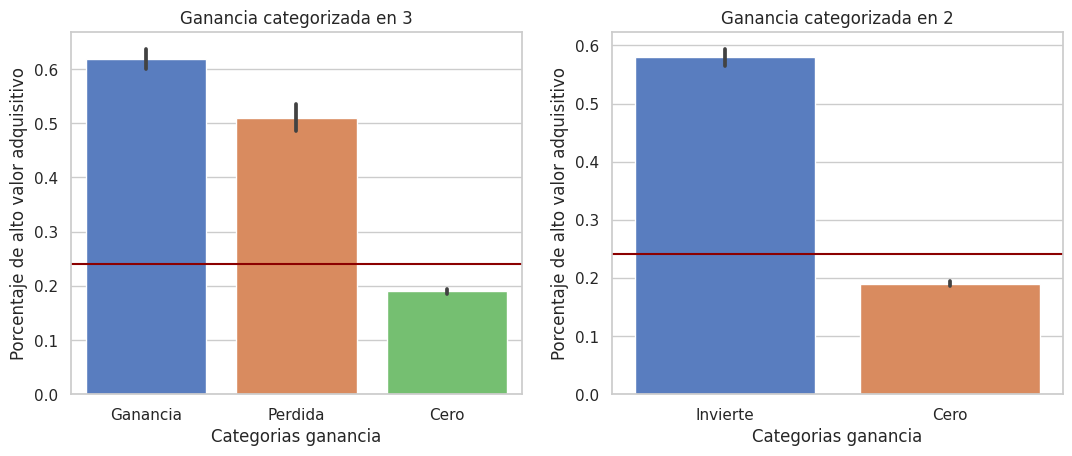

In [25]:
def categorizar_ganancia(df, categorizar_por):
    df_cat = df[['ganancia_perdida_declarada_bolsa_argentina','tiene_alto_valor_adquisitivo']].copy()
    df_cat['ganancia'] = df_cat['ganancia_perdida_declarada_bolsa_argentina'].apply(categorizar_por)
    df_cat['ganancia'].value_counts()
    indices_cat = df_cat.groupby('ganancia')['tiene_alto_valor_adquisitivo'].aggregate(lambda x: np.mean(x))
    return (df_cat, indices_cat)

df_gan_3_cat, indices_3_cat = categorizar_ganancia(df,lambda gan: 'Cero' if gan == 0 else ('Perdida' if gan < 0 else 'Ganancia'))
df_gan_2_cat, indices_2_cat = categorizar_ganancia(df,lambda gan: 'Cero' if gan == 0 else 'Invierte')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)
prom = df['tiene_alto_valor_adquisitivo'].mean()
sns.barplot(
    data=df_gan_3_cat,
    x='ganancia',
    y='tiene_alto_valor_adquisitivo',
    order= indices_3_cat.sort_values(ascending=False).index,
    ax=axes[0])
axes[0].set(title="Ganancia categorizada en 3",xlabel="Categorias ganancia",ylabel="Porcentaje de alto valor adquisitivo")
axes[0].axhline(prom, color="darkred", label="Promedio de personas con alto VA")

sns.barplot(
    data=df_gan_2_cat,
    x='ganancia',
    y='tiene_alto_valor_adquisitivo',
    order= indices_2_cat.sort_values(ascending=False).index,
    ax=axes[1])


axes[1].set(title="Ganancia categorizada en 2",xlabel="Categorias ganancia",ylabel="Porcentaje de alto valor adquisitivo")
axes[1].axhline(prom, color="darkred", label="Promedio de personas con alto VA")


plt.show()

Como se puede apreciar el gráfico de la izquierda transmite la misma información que el de la derecha, en el sentido que aun teniendo perdida el accionista tiene un porcentaje comparable al que registró una ganancia, es por ello que nos parece apropiado agruparlo en una categoría llamada Invierte. Otra cosa a notar es que como era de esperarse alguien que invierte tiene mayor poder adquisitivo que la media.

### ¿Que nivel de formacion academica es necesaria?

En general se esperaria que una persona con mas formacion califique para trabajos mas remunerados.

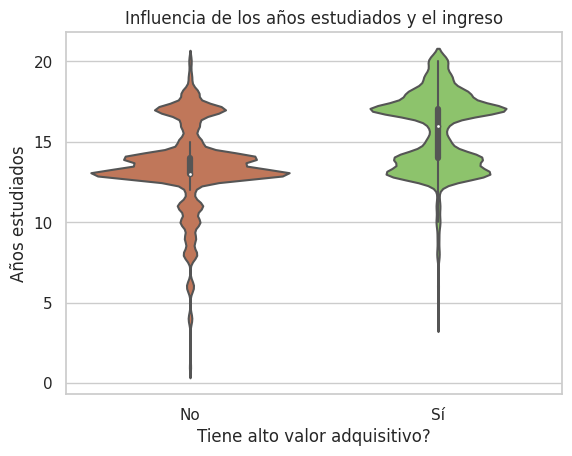

In [26]:
plt.figure(figsize=(6.4, 4.8),dpi=100)
plt.title("Influencia de los años estudiados y el ingreso")
sns.violinplot(
    data=df,
    y='anios_estudiados',
    x='tiene_alto_valor_adquisitivo',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Años estudiados")
plt.xlabel("Tiene alto valor adquisitivo?")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Podemos notar que existen 2 valores donde se acumula una gran parte de la población. En estos se encuentran las personas que terminaron el secundario (13 años) y la universidad o estudios terciarios (17 años). También podemos observar por debajo de 13 años la cantidad de personas con poder adquisitivo baja drásticamente, mientras que para el grupo con bajo poder adquisitivo va disminuyendo más lentamente (Ocurre el análisis inverso para valores mayores a 17 años).

#### ¿Que tanto influye la educacion en el trabajo?

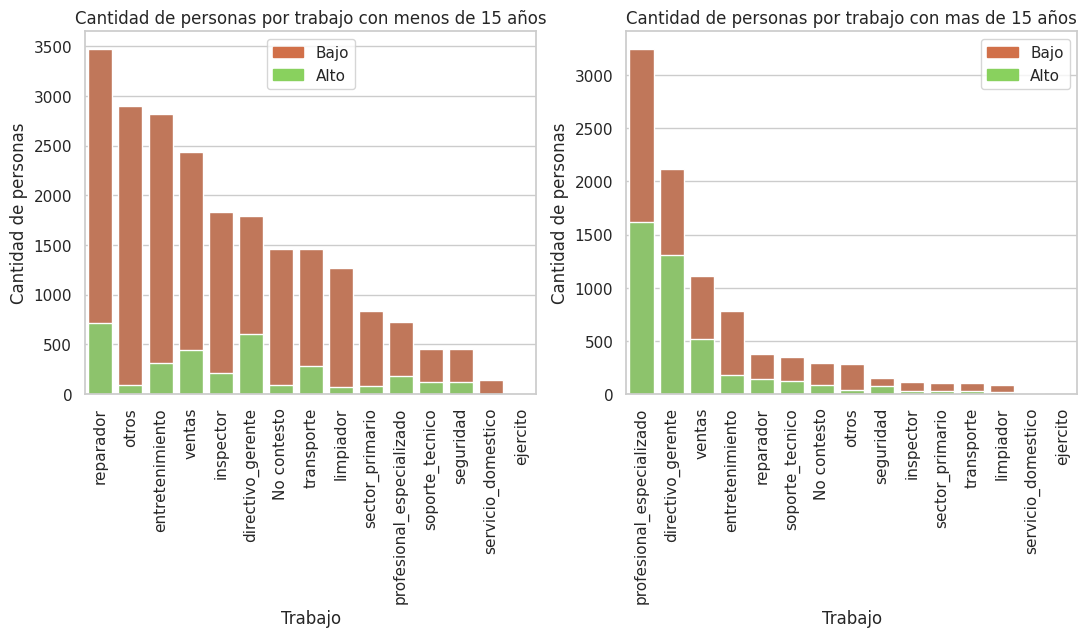

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_menor_15 = df[df['anios_estudiados'] < 15]
(top_bar, bottom_bar, bar1,bar2) = stacked_barplot(df_menor_15, 'trabajo', axes=axes[0])
axes[0].legend(handles=[top_bar, bottom_bar])
axes[0].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas por trabajo con menos de 15 años')
bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)

df_mayor_15 = df[df['anios_estudiados'] > 15]
(top_bar, bottom_bar, bar1,bar2) = stacked_barplot(df_mayor_15, 'trabajo', axes=axes[1])
axes[1].legend(handles=[top_bar, bottom_bar])
axes[1].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas por trabajo con mas de 15 años')
bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)
plt.show()

Como habíamos visto existen dos focos importantes donde se agrupa la mayor cantidad de gente y como podemos ver las personas con alto poder adquisitivo tienden a tener una mayor educación. Observamos que la separación no es tan marcada como por estado marital.

### ¿Es realmente influyente el domicilio legal?

En general existe el preasuncion de que la zona en la que una persona vive es reflejo de su poder adquisitivo.

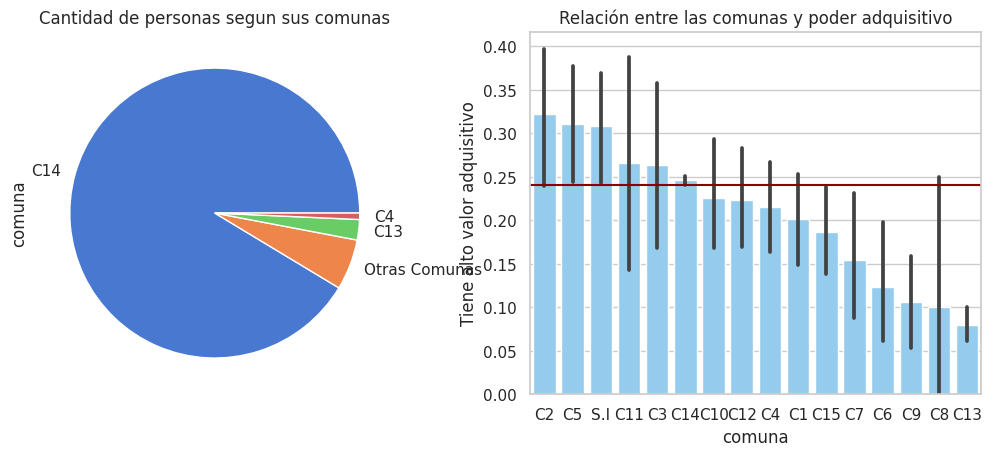

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_cantidades = df[['comuna', 'tiene_alto_valor_adquisitivo', 'estado_marital']].copy()

df_cantidades.loc[df_cantidades['comuna'].isin((df_cantidades['comuna'].value_counts()[df_cantidades['comuna'].value_counts() < 232]).index), 'comuna'] = 'Otras Comunas'
cantidades = df_cantidades['comuna'].value_counts()

cantidades.plot(
    kind='pie',
    ax = axes[0]
)
axes[0].set(title = 'Cantidad de personas segun sus comunas')


df_comunas = df[['comuna', 'tiene_alto_valor_adquisitivo']].copy()
indices = df_comunas.groupby('comuna')['tiene_alto_valor_adquisitivo'].aggregate(lambda x: np.mean(x))

ax = sns.barplot(
    data=df_comunas,
    x='comuna',
    y='tiene_alto_valor_adquisitivo',
    order= indices.sort_values(ascending=False).index,
    ax = axes[1],
    color =  "lightskyblue"
)

prom = df['tiene_alto_valor_adquisitivo'].mean()
axes[1].set(xlabel = 'comuna', ylabel = 'Tiene alto valor adquisitivo', title = 'Relación entre las comunas y poder adquisitivo')
axes[1].axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.show()

Podemos ver la gran cantidad de personas que residen en Palermo (un 90%), mientras que en el resto de comunas no hay la siguientes personas como para poder inferir estadísticamente sobre alguna relación entre el barrio y el poder adquisitivo.

### Tomando a la edad como un indicador promedio en la experiencia laboral. ¿Que tanto peso tiene con respecto a la capacidad financiera?

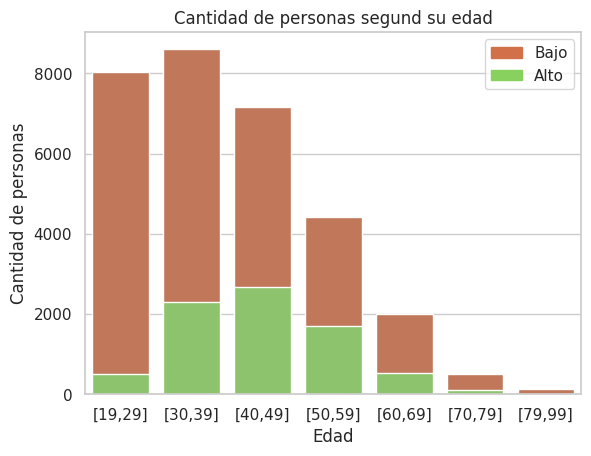

In [29]:
plt.figure(figsize=(6.4, 4.8),  dpi=100)

df_edad_categorizada = df[['edad', 'tiene_alto_valor_adquisitivo','trabajo','estado_marital']].copy()
categoria = pd.cut(df_edad_categorizada.edad,bins=[19,29,39,49,59,69,79,99],labels=['[19,29]', '[30,39]', '[40,49]', '[50,59]', '[60,69]', '[70,79]','[79,99]'])
df_edad_categorizada.insert(2,"Edad grupo", categoria)
df_edad_categorizada

(top_bar, bottom_bar, bar1,bar2) = stacked_barplot(df_edad_categorizada, 'Edad grupo', orden=False)

plt.legend(handles=[top_bar, bottom_bar])
plt.title("Cantidad de personas segund su edad")
plt.ylabel("Cantidad de personas")
plt.xlabel("Edad")


plt.show()

Podemos ver una clara diferencia en la distribución de las personas. El pico de gente con poder adquisitivo es de 45 años mientras que el de las personas con bajo poder adquisitivo es de 20 años.

Si bien es clara la existencia de un patrón distinto para cada uno de los grupos, la cantidad de personas de bajo poder adquisitivo dobla a la cantidad de personas de alto poder adquisitivo en el pico de esta última. Lo que hace difícil encontrar una regla para poder separarlos eficientemente.

#### ¿Existe una relacion entre el trabajo o el estado marital y la edad de una persona?

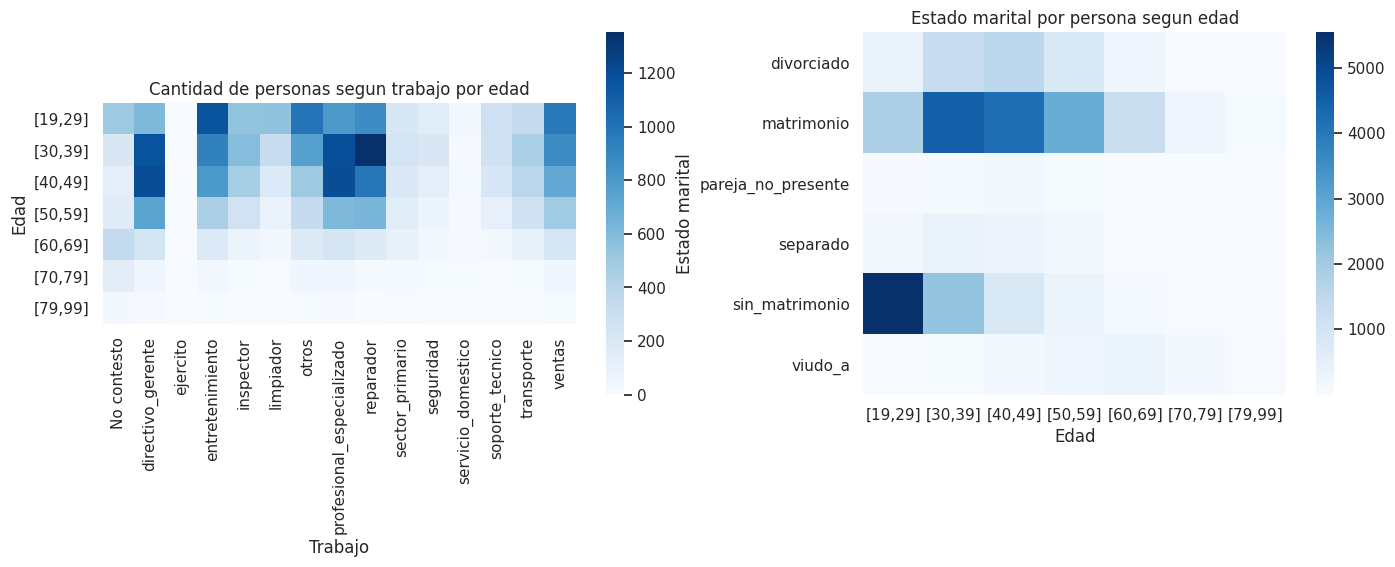

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[8.4 * 2, 4.8], dpi=100)


#plt.figure(figsize=(6.4, 4.8),  dpi=100)

df_temp = df_edad_categorizada.copy()

df_temp['unos'] = [1] * 32527
df_edad_trabajo= pd.pivot_table(
    df_temp,
    'unos',
    'Edad grupo',
    'trabajo',
    'count',
).sort_index()
#Elimino intersecciones nulas
df_edad_trabajo = df_edad_trabajo.replace({np.nan: 0})

sns.heatmap(df_edad_trabajo, square=True, cmap=heatmap_paleta, ax= axes[0])
axes[0].set(xlabel = 'Trabajo', ylabel= 'Edad', title = 'Cantidad de personas segun trabajo por edad')


#plt.figure(figsize=(6.4, 4.8),  dpi=100)


df_temp['unos'] = [1] * 32527
df_edad_trabajo= pd.pivot_table(
    df_temp,
    'unos',
    'estado_marital',
    'Edad grupo',
    'count',
).sort_index()
#Elimino intersecciones nulas
df_edad_trabajo = df_edad_trabajo.replace({np.nan: 0})

sns.heatmap(df_edad_trabajo, square=True, cmap=heatmap_paleta, ax= axes[1])
axes[1].set(xlabel = 'Edad', ylabel= 'Estado marital', title = 'Estado marital por persona segun edad')
plt.show()

Como podemos ver existen varios grupos visibles en el gráfico, por un lado sabemos que todas las personas que tienen entre 19 y 29 años en su gran mayoría son personas con bajo poder adquisitivo. Luego en la franja que va desde 30 hasta 50 años en el grafico de trabajo podemos distinguir 3 de profesiones con una gran cantidad de personas: gerente, profesional especializado y reparador. Por lo que podemos concluir que parece existir un patrón.

También al analizar la relación que existe con el estado marital notamos dos grupos bien definidos. Lo que nos interesa es la sección de gente entre 30 y 60 años los cuales principalmente se acumulan en la categoría de matrimonio.

Si bien existe la relación entre la edad y estas variables, condicionar por el matrimonio resulta similar a pedir que la población tenga mas de 29 años que es un grupo con bajo poder adquisitivo y por navaja de Ockham un modelo que logra lo mismo y pide menos es mejor que uno que pide más.

### ¿Es influyente factores como la religion o el genero para determinar el poder adquisitivo?

A priori uno creeria que la religion de una persona no afectaria en su poder adquisitio. Mientras que existe una posibilidad de una desigualdad basada en el genero.

#### Religion

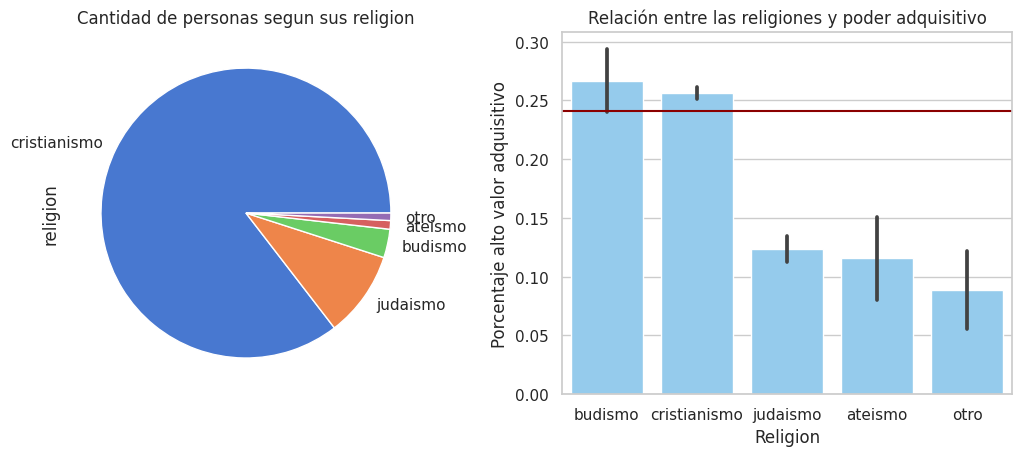

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df['religion'].value_counts().plot(
    kind='pie',
     ax = axes[0],
)
axes[0].set(title = 'Cantidad de personas segun sus religion')


df_religion = df[['religion', 'tiene_alto_valor_adquisitivo']].copy()
indices = df_religion.groupby('religion')['tiene_alto_valor_adquisitivo'].aggregate(lambda x: np.mean(x))

sns.barplot(
    data=df_religion,
    x='religion',
    y='tiene_alto_valor_adquisitivo',
    order= indices.sort_values(ascending=False).index,
    ax = axes[1],
    color =  "lightskyblue"
)

prom = df['tiene_alto_valor_adquisitivo'].mean()
axes[1].set(xlabel = 'Religion', ylabel = 'Porcentaje alto valor adquisitivo', title = 'Relación entre las religiones y poder adquisitivo')
axes[1].axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.show()

Como podemos ver la gran mayoría de personas son cristianas, luego existen dos grupos más reducidos que son el judaísmo y el budismo ya que tanto el ateísmo como la categoría 'otros' tiene muy poca gente como para poder inferir algo a partir de ellas.

Algo interesante es la baja cantidad de personas judías con alto poder adquisitivo, para buscar una explicación a esto decidimos graficar la religión contra variables que ya sabemos, por el análisis antes hecho, que son influyentes en el poder adquisitivo.

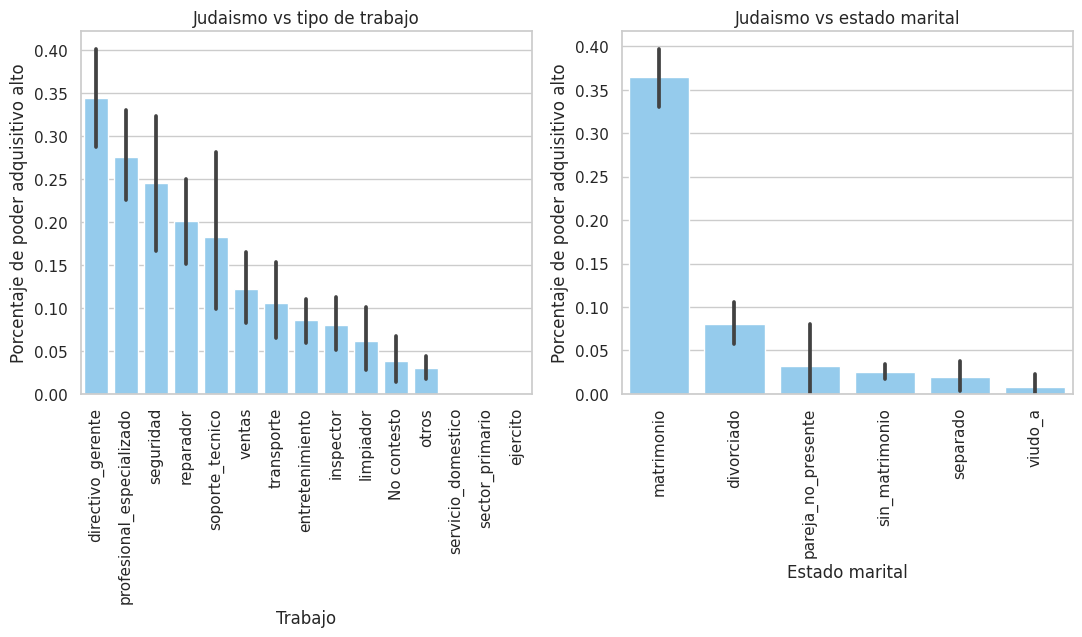

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_judaismo = df[df['religion'] == 'judaismo']

indices = df_judaismo.groupby('trabajo')['tiene_alto_valor_adquisitivo'].aggregate(lambda x: np.mean(x))

bar1=sns.barplot(
    data=df_judaismo,
    x='trabajo',
    y='tiene_alto_valor_adquisitivo',
    order= indices.sort_values(ascending=False).index,
    ax = axes[0],
    color = "lightskyblue"
)
axes[0].set(xlabel = 'Trabajo', ylabel= 'Porcentaje de poder adquisitivo alto', title = 'Judaismo vs tipo de trabajo')

bar2=sns.barplot(
    data=df_judaismo,
    x='estado_marital',
    y='tiene_alto_valor_adquisitivo',
    order= df_sin_crist.groupby('estado_marital')['tiene_alto_valor_adquisitivo'].aggregate(lambda x: np.mean(x)).sort_values(ascending=False).index,
    ax = axes[1],
    color = "lightskyblue"
)

bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)
axes[1].set(xlabel = 'Estado marital', ylabel= 'Porcentaje de poder adquisitivo alto', title = 'Judaismo vs estado marital')
plt.show()

Mirando estos gráficos podemos notar que este porcentaje bajo de personas con alto poder adquisitivo que tiene la religión judía, se debía a que solo un tercio de ellos están casados y tiene trabajos con alta remuneración como gerente y profesionales especializados.

#### Genero

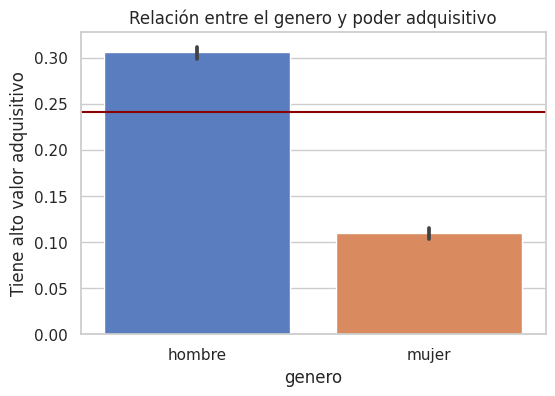

In [33]:
plt.figure(dpi=100)

ax = sns.barplot(
    data=df,
    y='tiene_alto_valor_adquisitivo',
    x='genero')


plt.xlabel("genero")
plt.ylabel("Tiene alto valor adquisitivo")
plt.title('Relación entre el genero y poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()
plt.axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.show()

Notamos una importante diferencia ente la cantidad de hombre y mujeres con alto poder adquisitivo. Por lo que decidimos buscar relaciones entre esta variable y las antes analizadas.

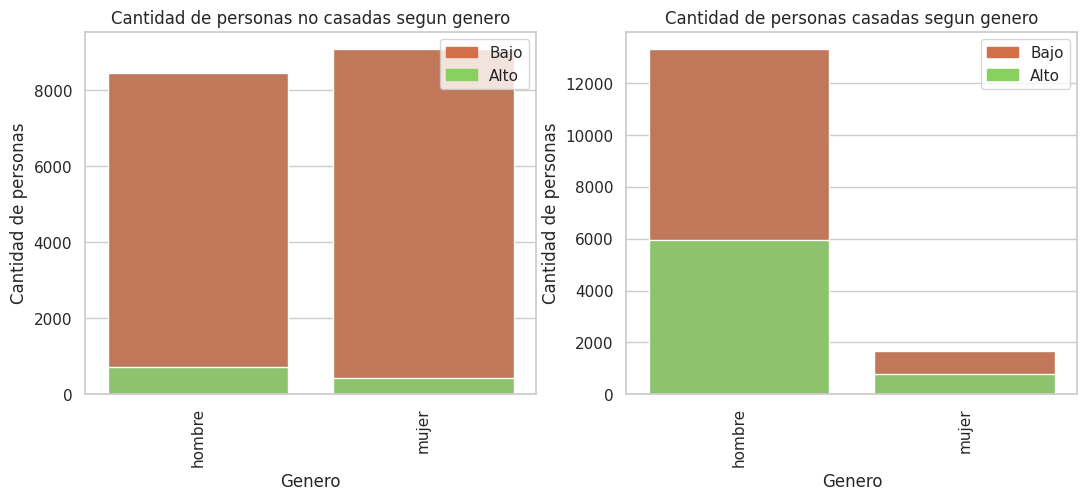

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_no_mat = df[df['estado_marital'] != 'matrimonio']
df_mat = df[df['estado_marital'] == 'matrimonio']

(top_bar, bottom_bar, bar1,bar2) = stacked_barplot(df_no_mat, 'genero', orden=False, axes=axes[0])
axes[0].legend(handles=[top_bar, bottom_bar])
axes[0].set(xlabel = 'Genero', ylabel= 'Cantidad de personas', title = 'Cantidad de personas no casadas segun genero')
bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)

(top_bar, bottom_bar, bar1,bar2) = stacked_barplot(df_mat, 'genero', orden=False, axes=axes[1])
axes[1].legend(handles=[top_bar, bottom_bar])
axes[1].set(xlabel = 'Genero', ylabel= 'Cantidad de personas', title = 'Cantidad de personas casadas segun genero')
bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)
plt.show()

Como podemos observar si bien las mujeres poseen menor poder adquisitivo que los hombres, al condicionar por el matrimonio se forman dos ramas en las que el genero deja de ser influyente, ya que ambas poseen el mismo porcentaje relativo.

## Conclusión:

A partir de los datos recolectados hemos podido obtener las siguientes conclusiones:
- La gente que se encuentra casada posee el mayor porcentaje de gente con poder adquisitivo alto siendo este el 84% de la gente con poder adquisitivo alto, y llevando un 32% de la gente de poder adquisitivo bajo, sin lugar a dudas tener una familia que mantener impulsa a los integrantes a ganar más de los que no.
- Hay trabajos que son mejores remunerados que otros siendo estos directivo gerente, profesional especializado y ventas, esto por sí solo no resulta tan bueno como lo anterior, pero condicionada a lo anterior se vuelve una gran regla de decisión, tan solo el 9% de la gente con bajo poder adquisitivo cumple esta condición, por lo que el error que se comete es despreciable.
- La formación académica comparada con el trabajo nos muestra que tener una formación de mayor de 15 años influye en el poder adquisitivo permitiendo ayudarnos a recuperar a un 10% de gente de poder adquisitivo alto, que no cumplia la condicion del trabajo.
- La edad si bien posee una interesante separación no resulta tan importante a la hora de analizar el perfil de persona con poder adquisitivo que se fue armando, en parte por la similitud que tiene con otras condiciones como pedir que las personas estén casadas.
- El género si bien presentó una interesante diferencia, siendo condicionada al matrimonio se distribuyo de forma similar perdiendo la influencia inicial.
- El barrio o en este caso las comunas no parecen influir tanto como uno puede llegar a presuponer, quizá pueda estar influenciado que el 90% de la muestra es solo de Palermo.
- La religión solo presento un caso fuera de lo común siendo este la religión judía pero analizando más en detalle se debió a que solo 1/3 de ellos se encontraban en categorías más influyentes como estar casados o trabajar en puestos altamente remunerados, por lo cual se decidió no tenerla en cuenta.

Por lo que como target, recomendamos basarse fuertemente en las personas que se encuentran en matrimonio y que poseen trabajos altamente remunerados como directivo gerente, profesional especializado o ventas, en caso de no poder satisfacer esta ultima condición pudimos verificar que la gente que estudió más de 15 años por lo general son lo suficiente competentes como para poder satisfacer la condición pedida.

## Baseline:

In [35]:
def baseline(X: pd.DataFrame):
    df = X.reset_index()
    # Inicializamos el vector de prediccion inicialmente con 0 y
    #vamos agregando las condiciones que creemos fundamentales
    pred = pd.Series(np.zeros(len(df)))
    
    # Primera condicion importante de nuestro baseline,
    # con ella separamos una gran parte de la poblacion 
    # 17550 que No y 14484 que Si
    # En el No cometemos tan solo un error en 1253,
    # Mientras que en el Si cometemos 
    # un error de 14484 personas (en caso de terminar el baseline aqui).
    # Es una buena condicion ya que nos permite quedarnos con el 
    # 85% de la gente de poder adquisitivo alto
    sos_casado = df['estado_marital'] == 'matrimonio'
    
    # Segunda condicion, anexada al Si de la condicion anterior
    # nos permite quedarnos en el caso de que la 
    # respueta sea satisfactoria con el 51% de la gente de poder adquisitivo alto
    # mientras que solo cometemos un error de 2222 personas.
    # Quedando en la rama del No solo un 34% de la gente con poder adquisitivo alto
    # y cometiendo un error de 2664 personas
    trabajas_en_puestos_importantes = (df['trabajo'] == 'directivo_gerente') | (df['trabajo'] == 'profesional_especializado') | (df['trabajo'] == 'ventas')
    
    # Tercera condicion que nos permite recuperar gente de la rama del no anterior,
    # anexada a las anteriores nos permite recuperar el 10% de la gente de poder adquisitivo alto,
    # cometiendo error en solo 1523 personas,
    # mientras que para el caso de los que no la cumplen solo cometemos
    # error en 1881 personas
    estudiaste_15_o_mas_anios = df['anios_estudiados'] >= 14.5
    
    # Armando las ramas
    sos_casado_y_ocupas_un_puesto_importante = sos_casado & trabajas_en_puestos_importantes
    sos_casado_y_no_ocupas_un_puesto_importante_y_si_estudiaste__mas_14_anios = sos_casado & (~trabajas_en_puestos_importantes) & estudiaste_15_o_mas_anios
    
    #Finalemente seteando en el vector de prediccion las condiciones 
    # que cosnideramos que cumple una persona con alto poder adquisitivo
    pred[sos_casado_y_ocupas_un_puesto_importante | sos_casado_y_no_ocupas_un_puesto_importante_y_si_estudiaste__mas_14_anios] = 1
    return pred.tolist()

#### Arbol de decisión
![Arbol de decision](arbol.png)

In [57]:
np.mean(df['tiene_alto_valor_adquisitivo'] == baseline(df)).round(3)

0.812